# Simulation Project
### Unni Kurumbail
### CBE 710
### Nov. 10, 2020


In [7]:
import unittest
import random as rd
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import pickle
import pathlib
import os
import warnings
%matplotlib inline
np.seterr(all='raise')
np.seterr()

{'divide': 'raise', 'invalid': 'raise', 'over': 'raise', 'under': 'raise'}

In [2]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  path = str(pathlib.Path().absolute()) + '/drive/My Drive'
  if not os.path.exists(path):
    raise Exception("{} does not exist".format(path))
except Exception:
  print(Exception)
  print('Google drive not located. Utilizing current directory as working directory for pickle files.')
  path = str(pathlib.Path().absolute())
print('Working directory: {}'.format(path))

Mounted at /content/drive
Working directory: /content/drive/My Drive


## Problem 1

### Problem 1 Overarching Code

In [8]:
class MCSim:

  parallel = 1
  antiparallel = -1
      
  def __init__(self,N=400,J=1.0,beta=0.1,init_distrib=None,order_init=False):

    try:


      self.J = J
      self.beta = beta
      self.sanitize(N=N,init_distrib=init_distrib)
      self.initialize_particles(N=N,init_distrib=init_distrib,order_init=order_init)
      self.N = self.state.shape[0]*self.state.shape[1]
      
      self.r_len, self.c_len = self.state.shape
      self.E = self.energy()
      self.M = self.magnetization()
      
      self.E_arr = []
      self.M_arr = []
      self.Swap_arr = []
      self.swapped = None
      self.num_saves = 0

    except Exception as e:
      raise e

  def sanitize(self,N=None,init_distrib=None):
    if N is not None:
      if N <= 0:
        raise ValueError("N must be greater than 0.")
      elif self.is_square(N) is False:
        raise NotImplementedError("N is not a perfect square- cannot yet simulate for non-square lattice.")
      elif type(N) != int:
        raise TypeError("N must be an integer.")
      else:
        pass

    if init_distrib is not None:
      if init_distrib.shape[0] != init_distrib.shape[1] or type(init_distrib) != np.ndarray:
        raise ValueError("Initial distribution provided must be a square 2-D Numpy Array.")
      else:
        pass
    
    return True

  def initialize_particles(self,N=None,init_distrib=None,order_init=False):
    if init_distrib is not None:
      self.state = init_distrib
    else:
      if order_init:
        self.state = np.random.choice([self.parallel],(int(N**0.5),int(N**0.5)),)
      else:
        self.state = np.random.choice([self.parallel, self.antiparallel],(int(N**0.5),int(N**0.5)),)

  def energy(self): #computes full energy
    energy = 0
    for i in range(self.r_len):
      for j in range(self.c_len):
        energy += self.particle_E((i,j))
    return energy / 2

  def magnetization(self): #computes magnetization of a state
    return np.sum(self.state)

  def particle_E(self,particle_indices): #computes energy for a specific particle
    row,col = particle_indices
    return -1*self.J*self.state[row,col]*(self.state[row,(col+1)%self.c_len] + 
                                self.state[row,(col-1)%self.c_len] + 
                                self.state[(row+1)%self.r_len,col] + 
                                self.state[(row-1)%self.r_len,col])

  def swap(self,particle_indices): #swaps the spin of a specific particle
    if self.state[particle_indices] == self.parallel:
        self.state[particle_indices]  = self.antiparallel
    else:
        self.state[particle_indices] = self.parallel

  def select_rd_particle(self): #randomly selects a particle from state
      return (np.random.randint(0,self.r_len),np.random.randint(0,self.c_len))

  def get_spin(self,particle_indices):
    return self.state[particle_indices]

  def is_square(self,N):
    return N**0.5 == int(N**0.5)

  def delta_E(self,proposed_swap_indices): #E_new - E_old
    return -2*self.particle_E(proposed_swap_indices)


  def evolve(self):
    rd_particle = self.select_rd_particle()
    delta_E = self.delta_E(rd_particle)
    if rd.uniform(0,1) < min(1,np.exp(-self.beta*delta_E)):
      self.swap(rd_particle)
      self.E += delta_E
      self.M += 2*self.get_spin(rd_particle)
      self.swapped = rd_particle
    else:
      self.swapped = None

  def record(self):
    self.E_arr.append(self.E)
    self.M_arr.append(self.M)
    self.Swap_arr.append(self.swapped)
    self.num_saves += 1

  def gen_results(self):
    return {"num_saves":self.num_saves,"E_arr":np.asarray(self.E_arr),"M_arr":np.asarray(self.M_arr),"Swap_arr:":self.Swap_arr}


    


def metroMC(N=100,J=1.0,beta=0.1,num_trials=1000000,init_distrib=None,burnout=False,verbose=False,save_rate=1,order_init=True,suppress=False):
  sys = MCSim(N=N,J=J,beta=beta,init_distrib=init_distrib,order_init=order_init)
  if not suppress:
    print("Simulation initialized. Starting energy: {} Starting magnetization {}".format(sys.E,sys.M))
    if verbose:
      print("Simulation values: beta = {:.4}    J = {}    N = {}    num_trials = {}".format(sys.beta,sys.J,sys.N,num_trials))
  if burnout:
    burnout_num = num_trials // 20 # 5% burnout
    if not suppress:
      print("Performing burnout for {} iterations...".format(burnout_num))
    for i in range(burnout_num):
      sys.evolve()
    if not suppress:
      print("Burnout complete. New starting energy: {} New starting magnetization: {}".format(sys.E,sys.M))
  
  sys.record() #save energy, mag, etc.


  for i in range(1,num_trials+1): #perform each metroMC trial
    sys.evolve() #evolve system
    if i % save_rate == 0:
      sys.record()
    if not suppress:
      if verbose:
        if i in [int(0.1*j*num_trials) for j in range(1,10)]:
          print("Completed {} iterations. Current energy: {} Current magnetization: {}".format(i,sys.E,sys.M))
       
  res = sys.gen_results()
  res["num_trials"] = num_trials
  return res

### Problem 1a
Below we run a Metropolis Monte Carlo simulation of 400 particles in a 2D Ising model. The simulation is run for temperatures extending from $0.1\epsilon / k_B$ to $6\epsilon / k_B$. Particles are initialized in a fully parallel lattice initially.

In [ ]:
T_arr =np.arange(0.1,6.1,0.1)
beta_arr = [1/i for i in T_arr]
avg_M_arr = []
avg_Cv_arr = []
avg_E_arr = []
J = 1
N = 400
num_trials = 1000000
save_rate = 500

for beta in beta_arr:
  print("\n")
  init_time = time.perf_counter()
  res = metroMC(N=N,J=J,num_trials=num_trials,beta=beta,burnout=True,verbose=False,save_rate=save_rate)
  fin_time = time.perf_counter()
  avg_M_per_spin = sum(res["M_arr"])/res["num_saves"]/N
  avg_Cv = np.average(np.square(res["E_arr"]))-np.average(res["E_arr"])**2
  avg_E_per_spin = np.average(res["E_arr"])/N
  print("Magnetization per spin estimated at: {:.4} \nHeat capacity estimated at: {:.4}. \nEnergy estimated at: {} \nTime for simulation: {}".format(avg_M_per_spin,avg_Cv,avg_E_per_spin,fin_time-init_time))
  avg_M_arr.append(avg_M_per_spin)
  avg_Cv_arr.append(avg_Cv)
  avg_E_arr.append(avg_E_per_spin)




Simulation initialized. Starting energy: -800.0 Starting magnetization 400
Performing burnout for 50000 iterations...
Burnout complete. New starting energy: -800.0 New starting magnetization: 400
Magnetization per spin estimated at: 1.0 
Heat capacity estimated at: 0.0. 
Energy estimated at: -2.0 
Time for simulation: 12.769198934999991


Simulation initialized. Starting energy: -800.0 Starting magnetization 400
Performing burnout for 50000 iterations...
Burnout complete. New starting energy: -800.0 New starting magnetization: 400
Magnetization per spin estimated at: 1.0 
Heat capacity estimated at: 0.0. 
Energy estimated at: -2.0 
Time for simulation: 12.455756636000018


Simulation initialized. Starting energy: -800.0 Starting magnetization 400
Performing burnout for 50000 iterations...
Burnout complete. New starting energy: -800.0 New starting magnetization: 400
Magnetization per spin estimated at: 1.0 
Heat capacity estimated at: 0.0. 
Energy estimated at: -2.0 
Time for simulati

Next the magnetization per particle, heat capacity, and energy per particle are plotted based on the above simulations.

Heat capacity is calculated via the equation:

$$C_v = \frac{<E^2>-<E>^2}{k_B T^2}$$

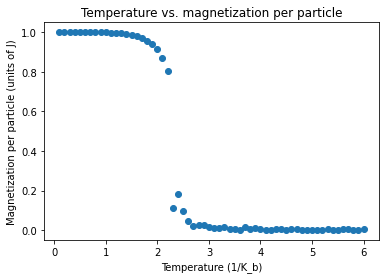

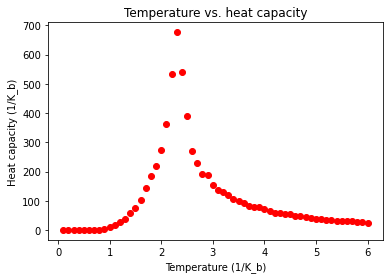

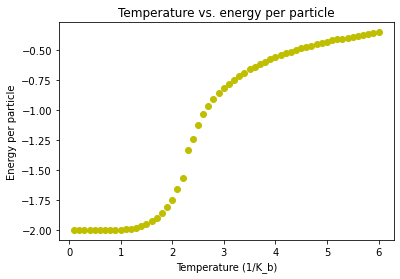

In [ ]:
plt.plot(T_arr,[abs(i) for i in avg_M_arr],'o')
plt.title('Temperature vs. magnetization per particle')
plt.xlabel('Temperature (1/K_b)')
plt.ylabel('Magnetization per particle (units of J)')
plt.show()

plt.plot(T_arr,np.asarray(avg_Cv_arr)/np.square(np.asarray(T_arr)),'ro')
plt.title('Temperature vs. heat capacity')
plt.xlabel('Temperature (1/K_b)')
plt.ylabel('Heat capacity (1/K_b)')
plt.show()

plt.plot(T_arr,avg_E_arr,'yo')
plt.title('Temperature vs. energy per particle')
plt.xlabel('Temperature (1/K_b)')
plt.ylabel('Energy per particle')
plt.show()

On the graphs above, a clear phase transition is observed in the 'kinked' heat capacity curve. This most likely corresponds to the capture of a latent heat of transition, where the heat capacity reflects the energy required to move the system from one phase to another.

### Problem 1b

Noting that $C_v = \left (\frac{\partial <E>}{\partial T}\right )_{N,V}$, we can see from the heat capacity plot in **1a** that the first derivative of energy (and therefore free energy because $F=E-TS$) is most likely continuous but not differentiable. This indicates that the ferromagnetic transition is a second-order phase transition, where the first derivative of free energy is calculable but the second derivative is not. 

In addition, per [these lecture notes](https://ps.uci.edu/~cyu/p238C/LectureNotes/PhaseTransitions/PhaseTransitions.pdf), a first-order phase transition is characterized by a discontinuous jump in entropy at the transition temperature (ex solid to liquid), and subsequently discontinuous jumps in free energy and magnetization. In our case, we see smooth changes in magnetization and energy, which leads me to believe that we have smooth changes in entropy with respect to temperature and therefore a second-order phase transition.

Furthermore, [Wikipedia](https://en.wikipedia.org/wiki/Phase_transition#Classifications) notes that first-order transitions are very much characterized by a latent heat. While we do see a non-differential peak in heat capacity at the critical temperature, it does not appear to be discontinuous. In my estimation, a latent heat would be characterized by a discontinuous heat capacity at $T_C$. This is another point indicating that this is most likely a second-order phase transition.

Finally, we note from Ryan's suggestion that:

$$dF = dE - d(ST) = (TdS - PdV) - SdT - TdS$$
so that
$$\frac{\partial F}{\partial T} = -P\frac{\partial V}{\partial T} - T\frac{\partial S}{\partial T}$$

but since this is constant-volume heat capacity,
$$\frac{\partial F}{\partial T} =  - T\frac{\partial S}{\partial T} = -C_V$$

Therefore, I would argue that since $C_V$, the first derivative of free energy, is not discontinuous, this does not represent a first-order phase transition and instead represents a second-order phase transition.


### Problem 1c
Since we assume the relationship between $T_C$ and $J$ is linear, we can write $$T_C = aJ + b$$ where $a$,$b$ are constants we will regress to find. First we define a function that can capture the phase-transition from a given plot of $T$ vs. $C_v$. We assume that the peak of the heat capacity plot represents the phase transition, and we plot each graph of $C_v(T)$ to make sure our peak represents a true peak.

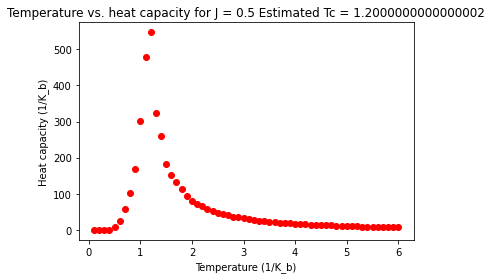

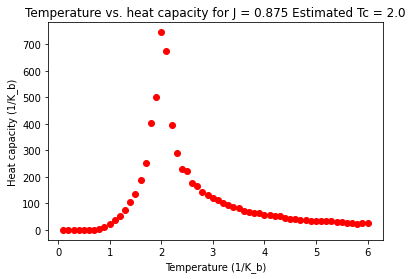

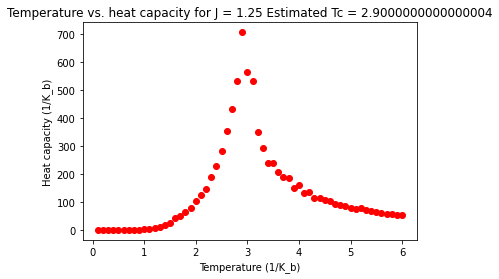

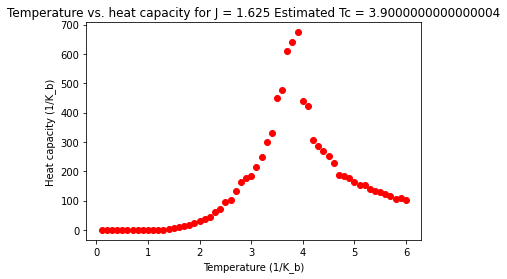

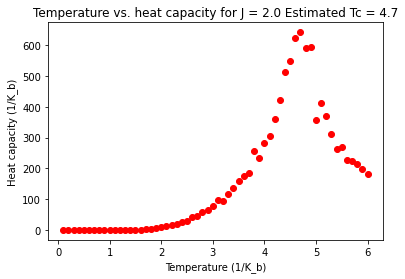

In [ ]:
def Tc(J): #Returns estimated Tc for a given J value

  T_arr =np.arange(0.1,6.1,0.1)
  beta_arr = [1/i for i in T_arr]
  avg_M_arr = []
  avg_Cv_arr = []
  avg_E_arr = []
  J = J
  N = 400
  num_trials = 1000000
  save_rate = 500

  for beta in beta_arr:
    init_time = time.perf_counter()
    res = metroMC(N=N,J=J,num_trials=num_trials,beta=beta,burnout=False,verbose=False,save_rate=save_rate,suppress=True)
    fin_time = time.perf_counter()
    avg_M_per_spin = sum(res["M_arr"])/res["num_saves"]/N
    avg_Cv = (np.average(np.square(res["E_arr"]))-np.average(res["E_arr"])**2)/(1/beta)**2
    avg_E_per_spin = np.average(res["E_arr"])/N
    avg_M_arr.append(avg_M_per_spin)
    avg_Cv_arr.append(avg_Cv)
    avg_E_arr.append(avg_E_per_spin)

  
  Cv_max_idx = avg_Cv_arr.index(max(avg_Cv_arr)) #code source: https://stackoverflow.com/questions/2474015/getting-the-index-of-the-returned-max-or-min-item-using-max-min-on-a-list
  plt.plot(T_arr,avg_Cv_arr,'ro')
  plt.title('Temperature vs. heat capacity for J = {} Estimated Tc = {}'.format(J,T_arr[Cv_max_idx]))
  plt.xlabel('Temperature (1/K_b)')
  plt.ylabel('Heat capacity (1/K_b)')
  plt.show()
  return T_arr[Cv_max_idx]


J_arr = np.linspace(0.5,2,5,endpoint=True)
Tc_arr = []
for J in J_arr:
  Tc_new = Tc(J)
  Tc_arr.append(Tc_new)

Next we perform a linear regression utilizing the equations from CBE 660:

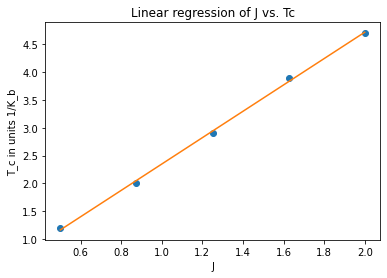

Estimated Coefficients: [-0.02666667  2.37333333]


In [ ]:
J_arr_temp = J_arr

ones_arr = np.ones(len(J_arr_temp))
A = np.column_stack((ones_arr,J_arr_temp))
A_T = np.transpose(A)
b = Tc_arr
coeffs = np.dot(np.linalg.inv(np.dot(A_T,A)),np.dot(A_T,b))
plt.plot(J_arr,Tc_arr,'o')
plt.plot(J_arr,np.dot(A,coeffs))
plt.xlabel('J')
plt.ylabel('T_c in units 1/K_b')
plt.title('Linear regression of J vs. Tc')
plt.show()
print('Estimated Coefficients: {}'.format(coeffs))



It looks like there is no y-intercept for this plot, so we conclude that

$$T_{c,\ MMC} \approx \frac{2.37J}{K_b}$$


Other values ([Source for Onsager](http://www.lps.ens.fr/~krzakala/ISINGMODEL.pdf)):

$$T_{c,\ mean-field} = \frac{4J}{K_b}$$
$$T_{c,\ Onsager} \approx \frac{2.269J}{K_b}$$

Therefore the Metropolis MC solution does a much better job of approaching the analytical solution than the mean-field approximation does. In particular, the mean-field approximation overestimates the critical temperature. 

The mean-field approximation specifies that the average spin of any particle's nearest neighbors can be approximated by the average spin of the system overall. Consider that the mean-field approximation is overestimating the temperature where $F_{unaligned} = F_{aligned}$. Noting that $F = E-TS$ there are a couple potential reasons here:

* Mean-field assumes a value of $E_{aligned}$ that is too negative. The implication here is that the lattice is locally more disordered than the mean-field approximation implies.
* Mean-field assumes a value of $E_{unaligned}$ that is too positive. The implication here is that the lattice is locally more ordered than the mean-field approximation implies (i.e. there are clusters of locally-aligned particles). This seems like the likely reason, as it maintains high entropy overall while still reducing energy through local clusters of aligned particles. One way to test this would be to look at the lattice of particles at equilibrium and see whether there are local clusters at $T>T_C$.


### Problem 1d

The competition shown in these phase transitions is between energy and entropy. Aligned particles have lower energy for $J>0$, but they are constrained by the alignment requirement and therefore have less configurational freedom. At low temperatures particles exhibit high-energy states with exponentially-less probability (recall $p(j) \propto e^{-\beta E(j)}$) and therefore the energetic contribution to free energy dominates the entropic contribution to free energy. Thus the system minimizes free energy by aligning the particles (corresponding to an average magnetization per spin of approximately 1). 

At high temperatures, the relative energy difference between aligned and unaligned particles is less important in the above probability, and therefore the reduced entropy of constraining the particles to the aligned state becomes more important. At some point, the system breaks down and maximizes entropy by randomizing particle orientation (corresponding to an average magnetization per spin of approximately 0). 

### Problem 1 Unit Tests

In [9]:
# https://stackoverflow.com/questions/40172281/unit-tests-for-functions-in-a-jupyter-notebook
class TestNotebook(unittest.TestCase):
    def test_initialization(self):
      test_N = 9
      state = MCSim(N=test_N)
      for i in range(int(test_N**0.5)):
        for j in range(int(test_N**0.5)):
          self.assertTrue(state.state[i][j] == state.parallel or state.state[i][j] == state.antiparallel)
      self.assertEqual(int(state.N**0.5),state.state.shape[0])
      self.assertEqual(int(state.N**0.5),state.state.shape[1])
      self.assertRaises(NotImplementedError,MCSim,N=12)
      self.assertRaises(ValueError,MCSim,N=-3)
      self.assertRaises(TypeError,MCSim,N=4.0)

    def test_basic_fxs(self):
      test_N = 9
      state = MCSim(N=test_N)
      state.state = np.asarray([[1,-1,1],
                      [1,-1,1],
                      [-1,1,1]])
      self.assertEqual(2,state.energy())
      self.assertEqual(3,state.magnetization())
      self.assertEqual(2,state.particle_E((1,1)))
      self.assertEqual(-2,state.particle_E((1,2)))
      self.assertEqual(-4,state.delta_E((1,1)))
      self.assertEqual(0,state.delta_E((1,0)))
      self.assertEqual(-8,state.delta_E((2,0)))

      state2 = copy.deepcopy(state)
      state2.state[2,0] = 1
      self.assertEqual(-6,state2.energy())
      self.assertEqual(-4,state2.particle_E((2,0)))
      self.assertEqual(8,state2.delta_E((2,0)))

      state3 = copy.deepcopy(state)
      state3.state[1,0] = -1
      self.assertEqual(2,state3.energy())
      self.assertEqual(0,state3.particle_E((1,0)))
      self.assertEqual(0,state3.delta_E((1,0)))

      state4 = copy.deepcopy(state)
      state4.state[1,1] = 1
      self.assertEqual(-2,state4.energy())
      self.assertEqual(-2,state4.particle_E((1,1)))
      self.assertEqual(4,state4.delta_E((1,1)))

    def test_evolution(self):
      init_arr = np.asarray([[1,1,1],
                              [1,1,1],
                              [1,1,1]])
      state = MCSim(init_distrib=init_arr,J = 2)
      
      
      self.assertEqual(-8,state.particle_E((0,0)))
      self.assertEqual(-36,state.E)
      self.assertEqual(9,state.M)
      self.assertEqual(16,state.delta_E((0,0)))
      while state.swapped is None:
        state.evolve()
      self.assertEqual(-20,state.E)
      self.assertEqual(7,state.M)


if __name__ == '__main__':
    main = TestNotebook()

    # This executes the unit test/(itself)
    import sys
    suite = unittest.TestLoader().loadTestsFromTestCase(TestNotebook)
    unittest.TextTestRunner(verbosity=4,stream=sys.stderr).run(suite)
#unittest.main(argv=[''], verbosity=2, exit=False)

test_basic_fxs (__main__.TestNotebook) ... ok
test_evolution (__main__.TestNotebook) ... ok
test_initialization (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.015s

OK


## Problem 2

### Problem 2 Overarching Code

#### Starter Code

In [3]:
# starter code

def AssembleCubeLattice( lattice_diameter, density, num_lattice_x, num_lattice_y, num_lattice_z ):

#AssembleCubeLattice
#   Creates a cubic arrangement of particles for initializing simulation
#   run
# Params:
#   lattice_diameter = distance between lattice points
#   density = number of particles / lattice_diam^3
#   num_lattice_x/y/z number of particles along each dimension

  
    # determine appropriate size of box 
    num_particles = num_lattice_x*num_lattice_y*num_lattice_z
    lin_density=(density)**(1/3)#we specify that each of the linear densities (num/length) must be the same
    box_size = 1/lin_density*np.asarray([num_lattice_x, num_lattice_y, num_lattice_z])#Then we can specify the length from the number in each dimention
    # cartesian positions of each lattice point
    pos=np.zeros([num_particles, 3])
    
    # spatial increments in x/y dimension for making lattice
    incr_x = lattice_diameter
    incr_y = lattice_diameter
    incr_z = lattice_diameter
    # place all lattice points now
    bead_index = 0
    for i in range(num_lattice_z):
        for j in range(num_lattice_y):
            for k in range(num_lattice_x):
                pos[bead_index, 0] = k*incr_x + 0.5*lattice_diameter
                pos[bead_index, 1] = j*incr_y + 0.5*lattice_diameter
                pos[bead_index, 2] = i*incr_z + 0.5*lattice_diameter
                bead_index = bead_index + 1

    return pos, box_size

def AssignInitialVelocities( temp, k_b, mass, num_particles ):
# AssignInitialVelocities
#   Randomly assigns velocities drawn from a Maxwell-Boltzmann distribution
#   at the desired temperature. Removes any overall center-of-mass motion
#   to prevent the "flying Iceberg" problem. Rescales velocities to obtain
#   correct temperature after removing COM motion.
# Params:
#   temp = temperature used to initialize velocities
#   k_b = value of boltzmann constant
#   mass = mass of each particle
#   num_particles = number of total particles in system. 

    # define invmass, used below
    invmass = 1.0/mass
    # Initialize array.
    vels = np.zeros([num_particles, 3])
    
    # get 3 randomly generated numbers sampled from a normal (Gaussian)
    # distribution as opposed to uniform distribution
    for i in range(num_particles):
        # Maxwell-Boltzmann distribution for velocities is a Gaussian
        # distribution with mean = 0 and standard deviation = sqrt(kT/m).
        # randn(3,1) generates 3 random numbers from a Gaussian
        # distribution with mean = 0 and standard devition = 1. A property
        # of a variable, X, that is Gaussian distributed is that
        # multiplying by a factor A does not change its mean, but
        # multiplies its standard deviation by A. Therefore we multiply the
        # results of randn() by the desired standard deviation to draw from
        # a M-B distribution.
        vels[i,:] = np.random.randn(3)*(k_b*temp*invmass)**(1/2)


    # A few tricks here want to prevent the entire system having a net
    # velocity (flying ice box), so we remove center of mass velocity from each
    # particle to set center of mass velocity to 0.
    com_vel = np.zeros([1, 3])
    for i in range(num_particles):
        com_vel = com_vel + vels[i, :]
    com_vel = com_vel / num_particles
    for i in range(num_particles):
        vels[i,:] = vels[i, :] - com_vel
    
    # Next, rescale velocities by calculating current temperature, then multiplying
    # all velocities uniformly to get new correct temperature. Calculate temperature from
    # T = 2/3k * KE = 1/3k * m v^2
    # Could have combined with above step, but keep separate to show main
    # idea.
    
    cur_ke = 0.0
    for i in range(num_particles):
       cur_ke = cur_ke + 0.5*mass*np.dot(vels[i, :], vels[i, :]) 

    cur_temp = 0.66 * cur_ke / num_particles
    # Get scaling factor
    scale_factor = np.sqrt(temp /cur_temp) 
    # multiply all velocities by scale factor to get new correct temp
    new_ke = 0.0
    for i in range(num_particles):
        vels[i,:] = vels[i,:] * scale_factor
        new_ke = new_ke + 0.5*mass*np.dot(vels[i,:], vels[i,:]) 
   
    rescale_temp = 0.66 * new_ke / num_particles
    print('Original temp =',cur_temp ,', rescaled temp =',  rescale_temp)
    return vels

def Plot_3D_configuration(pos, plot_num=1, **kwargs):
    #pos should be a final configuration of your atoms, as an n x 3 array.
    #identitiy should be a set of ones and zeros, which will tell you which component is which for part f
    #by default, you should make identity a set of zeros
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    size=np.shape(pos)
    number=size[0]
    if ('identity' in kwargs):
      identity=np.asarray(kwargs['identity'])
    else:
      identity=np.ones(number)
    colors=np.transpose([identity,np.zeros(number),1-identity])
    if ('title' in kwargs):
      title=kwargs['title']
    else:
      title='Output Configuration'
    plt.close(plot_num)
    fig=plt.figure(plot_num)
    ax=fig.gca(projection='3d')
    x,y,z=pos[:,0],pos[:,1],pos[:,2]
    ax.scatter(x,y,z,c=colors,s=100)
    """                                                                                                                                                    
    Scaling is done from here...                                                                                                                           
    """
    x_scale=np.ceil(np.max(x))+1
    y_scale=np.ceil(np.max(y))+1
    z_scale=np.ceil(np.max(z))+1
    
    scale=np.diag([x_scale, y_scale, z_scale, 1.0])
    scale=scale*(1.0/scale.max())
    scale[3,3]=0.75
    
    def short_proj():
      return np.dot(Axes3D.get_proj(ax), scale)
    
    ax.get_proj=short_proj
    """                                                                                                                                                    
    to here                                                                                                                                                
    """
    '''
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
    Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x.max()+x.min())
    Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y.max()+y.min())
    Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z.max()+z.min())
    # Comment or uncomment following both lines to test the fake bounding box:
    for xb, yb, zb in zip(Xb, Yb, Zb):
       ax.plot([xb], [yb], [zb], 'w')
    '''
    ax.set_xlabel('X axis',fontsize=16)
    ax.set_ylabel('Y axis',fontsize=16) 
    ax.set_zlabel('Z axis',fontsize=16)
    ax.set_xticks(np.arange(0,np.ceil(np.max(x))+1))
    ax.set_yticks(np.arange(0,np.ceil(np.max(y))+1))
    ax.set_zticks(np.arange(0,np.ceil(np.max(z))+1))
    ax.set_xticklabels(np.arange(0,int(np.ceil(np.max(x))+1)),fontsize=12)
    ax.set_yticklabels(np.arange(0,int(np.ceil(np.max(y))+1)),fontsize=12)
    ax.set_zticklabels(np.arange(0,int(np.ceil(np.max(z))+1)),fontsize=12)
    ax.set_title(title,fontsize=16)
    return

def Make_3D_animation(pos_save,**kwargs):
    #pos should be a final configuration of your atoms, as an m x n x 3 array. where m is number of steps, and n is number of particles
    #identity should be a set of ones and zeros, which will tell you which component is which for part f
    #by default, you should make identity a set of zeros
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.mplot3d import proj3d
    import matplotlib.animation as animation
    pos_save=np.asarray(pos_save)
    size=np.shape(pos_save)
    number_particles=size[1]
    number_frames=size[0]
    if ('identity' in kwargs):
      identity=np.asarray(kwargs['identity'])
    else:
      identity=np.ones(number_particles)
    colors=np.transpose([identity,np.zeros(number_particles),1-identity])
    if ('title' in kwargs):
      title=kwargs['title']
    else:
      title='Animations at frame'
    fig=plt.figure(figsize=(8,6))
    ax=fig.add_subplot(111,projection='3d')
    
      
    x,y,z=pos_save[:,:,0],pos_save[:,:,1],pos_save[:,:,2]
    #ax.scatter(x,y,z,c=colors,s=100)
    
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
    Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x.max()+x.min())
    Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y.max()+y.min())
    Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z.max()+z.min())
    # Comment or uncomment following both lines to test the fake bounding box:
    for xb, yb, zb in zip(Xb, Yb, Zb):
       ax.plot([xb], [yb], [zb], 'w')
   
    ax.set_xlabel('X axis',fontsize=16)
    ax.set_ylabel('Y axis',fontsize=16) 
    ax.set_zlabel('Z axis',fontsize=16)
    
    
    ax.set_xticks(np.arange(0,np.ceil(np.max(x))+1))
    ax.set_yticks(np.arange(0,np.ceil(np.max(y))+1))
    ax.set_zticks(np.arange(0,np.ceil(np.max(z))+1))
    ax.set_xticklabels(np.arange(0,int(np.ceil(np.max(x))+1)),fontsize=12)
    ax.set_yticklabels(np.arange(0,int(np.ceil(np.max(y))+1)),fontsize=12)
    ax.set_zticklabels(np.arange(0,int(np.ceil(np.max(z))+1)),fontsize=12)
    """                                                                                                                                                    
    Scaling is done from here...                                                                                                                           
    """
    '''
    x_scale=np.ceil(np.max(x))+1
    y_scale=np.ceil(np.max(y))+1
    z_scale=np.ceil(np.max(z))+1
    
    scale=np.diag([x_scale, y_scale, z_scale, 1.0])
    scale=scale*(1.0/scale.max())
    scale[3,3]=0.75
    
    def short_proj():
      return np.dot(Axes3D.get_proj(ax), scale)
    
    ax.get_proj=short_proj
    '''
    """                                                                                                                                                    
    to here                                                                                                                                                
    """
    Title=ax.set_title(title,fontsize=16)
    def update_graph(num):
      graph._offsets3d=(x[num,:], y[num,:],z[num,:] )
      Title.set_text(title+'time='+str(num))
    
    #ims.append((plt.scatter(x[i,:],y[i,:],c=colors,s=100)))
    vol=np.max([np.max(x),np.max(y),np.max(z)])
    rel_size=5000/vol
    graph=ax.scatter(x[0,:], y[0,:],z[0,:],c=colors,s=rel_size)
    im_ani = animation.FuncAnimation(fig, update_graph,number_frames, interval=5, repeat_delay=300,
                                       blit=False)
    # To save this second animation with some metadata, use the following command:
#    im_ani.save('im.mp4', metadata={'artist':'Guido'})
    #plt.tight_layout()
    plt.show(im_ani)
    
    return im_ani   

#### Bespoke Code

In [6]:
class MDSim():
  #I sincerely apologize for how abstruse this is. I optimized through vectorizing literally everything (you won't find a for loop in here...).
  #On the bright side, the execution time is waaaaaay faster. For 125 particles, 30 iterations used to take 5-10s, now it takes ~ 0.3s.
  lattice_diameter = 1
  k_b = 1
  m = 1.0
  delta_t = 0.001
  eta = 1

  def __init__(self,N=125,T=1.2,t=1000000,density=0.85):

    self.density = density #partcles / sigma**3
    self.T = T
    self.N = N
    self.t=t
    num_lattice_x = num_lattice_y = num_lattice_z = round(self.N**(1/3)) #particles
    self.pos, self.box_size = AssembleCubeLattice( self.lattice_diameter, self.density, num_lattice_x, num_lattice_y, num_lattice_z )
    self.L = self.box_size[0] #units of sigma
    self.veloc = AssignInitialVelocities(self.T, self.k_b, self.m, self.N)

    self.forces = self.compute_forces()

    self.PE_rec = np.empty(t)
    self.KE_rec = np.empty(t)
    self.veloc_rec = [[] for t in range(t)]
    self.pos_rec = [[] for t in range(t)]
    
    
    



  def PBC(self,deltas): #in these comments, i & j refer to particle indices and x,y,z refer to the k=3 dimensions
    mask = np.where(deltas > 0,1,-1) #Make a mask before taking abs value to identify relative positions in each dimension
    boundary_particles = self.L - np.abs(deltas) #compute periodic boundary particle distance
    return np.where(boundary_particles < np.abs(deltas), np.multiply(-mask,boundary_particles),deltas) #select whether to use mirror particle based on distance, return with proper force orientation

  def LJ(self,deltas,distances):
    #deltas: Numpy vector: [delta_x,delta_y,delta_z]
    #distance: Float
    f = deltas * -48/(np.square(distances))*(np.power(distances,-12) - 0.5 * np.power(distances,-6)) #distance has units of sigma
    return f
    
  def compute_forces(self,force=None): #computes force on each particle
    if force is None:
      force = self.LJ
    deltas = -(self.pos[:,np.newaxis] - self.pos) #generates a 3-D array: i, j = particles & k = [x,y,z]
    deltas = self.PBC(deltas) #applies periodic boundary condition / mirror image convention
    self.dist_mat = np.linalg.norm(deltas,axis=2)
    np.fill_diagonal(self.dist_mat,np.nan)
    distances = np.reshape(np.repeat(self.dist_mat,3),(self.N,self.N,3)) #creating a matrix that plays nice with vectorized LJ function
    forces = force(deltas,distances)
    return np.nansum(forces,axis=1) # produces an Nx3 force matrix

  def execute(self): #performs each simulation using Velocity-Verlet algorithm from class
    self.pos += self.veloc * self.delta_t + self.forces / (2*self.m) * (self.delta_t)**2 #2x speed up versus rewriting self.pos. Unbelievable!
    self.pos = self.pos % self.L #PBC
    self.veloc += 1/(2*self.m) * self.forces * self.delta_t #half-int
    self.forces = self.compute_forces()
    self.veloc += 1/(2*self.m) * self.forces * self.delta_t
    self.KE = 1/2 * self.m * np.sum(np.square(np.linalg.norm(self.veloc,axis=1)))
    self.PE = np.nansum(4 * (self.dist_mat**(-12) -self.dist_mat**(-6)))/2
      
  def record(self,t): #records values for posterity
    self.pos_rec[t] = self.pos
    self.veloc_rec[t] = self.veloc
    self.KE_rec[t] = self.KE
    self.PE_rec[t] = self.PE

  def thermostat(self): #returns 3-D M-B velocity if random alpha < (collision frequency * delta_t)
    alphas = np.repeat(np.random.rand((self.N))[:,np.newaxis],3,axis=1) # ex. [[0.234,0.234,0.234],[0.123,0.123,0.123],...]
    alphas[0,:] = 0.0002
    self.veloc = np.where(alphas < self.eta*self.delta_t,np.random.normal(0,np.sqrt(self.T/self.m),(self.N,3)),self.veloc)

  def generate_values(self):
    return {'pos':self.pos_rec,
            'veloc':self.veloc_rec,
            'KE':self.KE_rec,
            'PE':self.PE_rec,
            'delta_t':self.delta_t,
            'density':self.density,
            'T':self.T,
            'N':self.N,
            't':self.t,
            'L':self.L,
    }


def run_MD(N=125,T=1.2,t=1000000,density=0.85,path=None,force_run=False,thermostat=False):
  if path is None:
    path = './'
  if not os.path.exists(path+'pickles/'):        
    os.makedirs(path+'pickles/')
  if not os.path.exists(pickle_file) or force_run:        
    print("Oh you sweet summer child. You thought you had run that simulation before? Nope- I'll run it now:")
    sim = MDSim(N=N,T=T,t=t,density=density)
    print("Beginning simulation with parameters: N = {} T = {} density = {} t = {}".format(sim.N,sim.T,sim.density,sim.t))
    if thermostat:
      print("Utilizing thermostat! Keepin it toasty...")
    init_time = time.perf_counter()
    for t in range(t):
      sim.execute()
      sim.record(t)
      if thermostat:
        sim.thermostat()
    sim_time = time.perf_counter()-init_time
    save_data = sim.generate_values()
    print("Simulation completed. Total simulation time: {}".format(sim_time))
    with open(pickle_file,mode="wb") as f:
      save_data["sim_time"] = sim_time
      pickle.dump(save_data,f)
  else:
    print("Looks like you have run the simulation with these parameters before. I'll just pull in that data and run the analysis for you:")
    with open(pickle_file,mode="rb") as f:
      save_data=pickle.load(f)
    try:
      print("Loading simulation... Parameters: N = {} T = {} density = {} t = {}".format(save_data["N"],save_data["T"],save_data["density"],save_data["t"]))      
      print("Total simulation time: {:.5}s".format(save_data["sim_time"]))
    except KeyError as e:
      print("Unable to load previous parameters and simulation time. Only returning simulation pos, veloc, KE, & PE.")
  return save_data
  





  
    

### Problem 2a

Below we generate, run, and plot an MD simulation for $N=125$, $\rho=0.85$, and $T=1.2$.


Looks like you have run the simulation with these parameters before. I'll just pull in that data and run the analysis for you:
Loading simulation... Parameters: N = 125 T = 1.2 density = 0.85 t = 100000
Total simulation time: 1178.9s


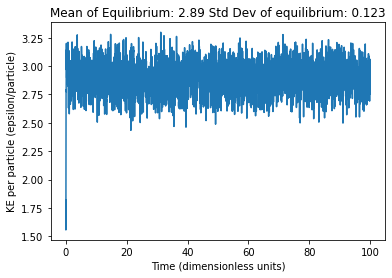

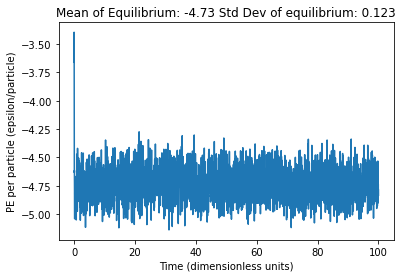

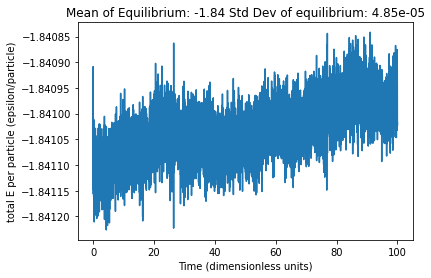

In [ ]:
trials = 100000
trials_arr = np.array([t for t in range(trials)])
time_arr = trials_arr/1000
N = 125
T = 1.2
version = 1
density = 0.85
pickle_file=path+'/pickles/MD_simulation_'+str(N)+'_'+str(density)+'_'+str(T)+'_'+str(trials)+'_'+str(version)+'.p'
res = run_MD(N=N,T=T,t=trials,density=density,path=pickle_file)
plt.plot(time_arr,res['KE']/N)
plt.title('Mean of Equilibrium: {:.3} Std Dev of equilibrium: {:.3}'.format(np.mean(res['KE'][20000:]/N),np.std(res['KE'][20000:]/N)))
plt.ylabel('KE per particle (epsilon/particle)')
plt.xlabel('Time (dimensionless units)')
plt.show()
plt.plot(time_arr,res['PE']/N)
plt.title('Mean of Equilibrium: {:.3} Std Dev of equilibrium: {:.3}'.format(np.mean(res['PE'][20000:]/N),np.std(res['PE'][20000:]/N)))
plt.ylabel('PE per particle (epsilon/particle)')
plt.xlabel('Time (dimensionless units)')
plt.show()
plt.plot(time_arr,(res['PE']+res['KE'])/N)
plt.title('Mean of Equilibrium: {:.3} Std Dev of equilibrium: {:.3}'.format(np.mean(res['PE'][20000:]/N + res['KE'][20000:]/N),np.std((res['PE'][20000:]/N + res['KE'][20000:]/N))))
plt.ylabel('total E per particle (epsilon/particle)')
plt.xlabel('Time (dimensionless units)')
plt.show()
# mat = np.isclose(sim.forces,np.zeros((125,3)))
# n=0
# for z in range(5):
#   for y in range(5):
#     for x in range(5):
#       print("x: {} y: {} z: {}".format(x,y,z),mat[n])
#       n += 1

# Make_3D_animation(res["pos"])

This simulation appears to converge very rapidly. As we'd expect, the total energy remains approximately constant (there is a slight upshift that is miniscule relative to the size of the total energy. This might reflect errors with floating point precision). Zooming in on the first two time units for total energy: 


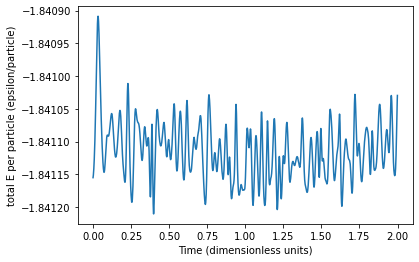

In [ ]:
plt.plot(time_arr[0:2000],(res['PE'][0:2000]+res['KE'][0:2000])/N)
plt.ylabel('total E per particle (epsilon/particle)')
plt.xlabel('Time (dimensionless units)')
plt.show()


It appears we equilibrate around 0.25 time units into the simulation, or 250 iterations in. Looking at the relative energies, it's apparent that at equilibrium we have a larger contribution from potential energy than kinetic energy. Both energies experience a dramatic shift at the beginning. Therefore, we'd expect an Anderson thermostat enforcing a temperature of of $1.2\epsilon / k_B$ to influence their ratios.

### Problem 2b

Next we run the same simulation, except this time we enforce a constant temperature of $T=1.2\epsilon / k_B$ through the Anderson thermostat.

Looks like you have run the simulation with these parameters before. I'll just pull in that data and run the analysis for you:
Loading simulation... Parameters: N = 125 T = 1.2 density = 0.85 t = 100000
Total simulation time: 1189.9s


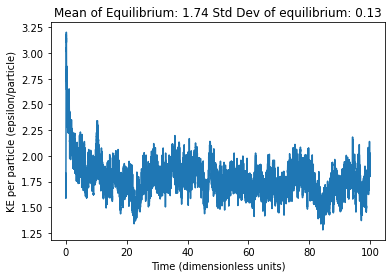

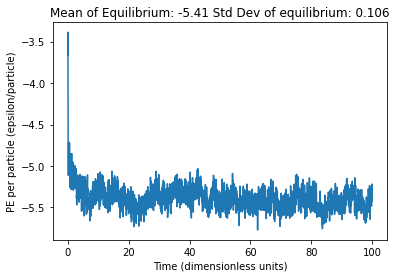

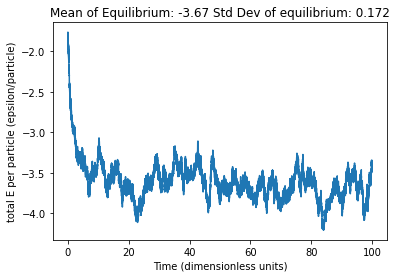

In [ ]:
trials = 100000
trials_arr = np.array([t for t in range(trials)])
time_arr = trials_arr/1000
N = 125
T = 1.2
version = 1
density = 0.85
pickle_file=path+'/pickles/MD_simulation_'+str(N)+'_'+str(density)+'_'+str(T)+'_'+str(trials)+'_'+str(version)+'_'+'thermostat'+'.p'
res = run_MD(N=N,T=T,t=trials,density=density,path=pickle_file,thermostat=True)
plt.plot(time_arr,res['KE']/N)
plt.title('Mean of Equilibrium: {:.3} Std Dev of equilibrium: {:.3}'.format(np.mean(res['KE'][20000:]/N),np.std(res['KE'][20000:]/N)))
plt.ylabel('KE per particle (epsilon/particle)')
plt.xlabel('Time (dimensionless units)')
plt.show()
plt.plot(time_arr,res['PE']/N)
plt.title('Mean of Equilibrium: {:.3} Std Dev of equilibrium: {:.3}'.format(np.mean(res['PE'][20000:]/N),np.std(res['PE'][20000:]/N)))
plt.ylabel('PE per particle (epsilon/particle)')
plt.xlabel('Time (dimensionless units)')
plt.show()
plt.plot(time_arr,(res['PE']+res['KE'])/N)
plt.title('Mean of Equilibrium: {:.3} Std Dev of equilibrium: {:.3}'.format(np.mean(res['PE'][20000:]/N + res['KE'][20000:]/N),np.std((res['PE'][20000:]/N + res['KE'][20000:]/N))))
plt.ylabel('total E per particle (epsilon/particle)')
plt.xlabel('Time (dimensionless units)')
plt.show()

This simulation takes longer to settle down, and looks to reach its stationary point around 20 time units or 20000 iterations. There is roughly the same noise in kinetic and potential energy (somewhere around 0.13 $\epsilon$), but there is considerably more noise in the total energy (consistent with it not being constantly minimized, unlike the microcanonical ensemble in **2a**).

The system  in **2b** achieves a lower potential energy per particle- one explanation for this is that the kinetic energy per particle is lower as well. As a result, the system is at a lower temperature, and therefore the energetic contribution to the overall free energy becomes more significant and thus further minimized. In this reading of the data, the Anderson thermostat can be considered an external constraint added to the system, artificially maintaining a lower temperature and therefore ending at a higher total energy per particle (which is no longer minimized), but a lower potential energy per particle. 


### Problem 2c

Below we plot the speed distributions for the simulations from **2a** and **2b**.

Looks like you have run the simulation with these parameters before. I'll just pull in that data and run the analysis for you:
Loading simulation... Parameters: N = 125 T = 1.2 density = 0.85 t = 100000
Total simulation time: 1178.9s
Looks like you have run the simulation with these parameters before. I'll just pull in that data and run the analysis for you:
Loading simulation... Parameters: N = 125 T = 1.2 density = 0.85 t = 100000
Total simulation time: 1189.9s


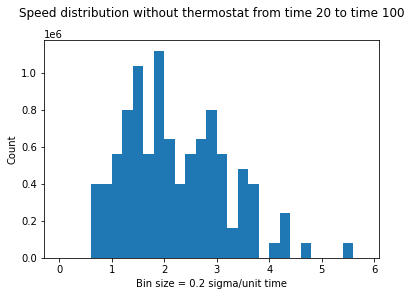

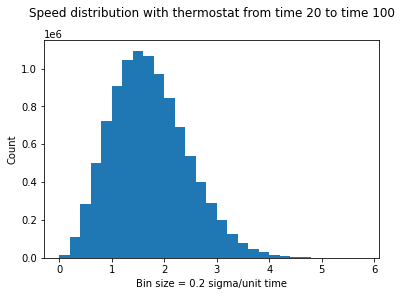

In [ ]:
trials = 100000
trials_arr = np.array([t for t in range(trials)])
time_arr = trials_arr/1000
N = 125
T = 1.2
version = 1
density = 0.85
pickle_file=path+'/pickles/MD_simulation_'+str(N)+'_'+str(density)+'_'+str(T)+'_'+str(trials)+'_'+str(version)+'.p'
res_2a = run_MD(N=N,T=T,t=trials,density=density,path=pickle_file)
pickle_file=path+'/pickles/MD_simulation_'+str(N)+'_'+str(density)+'_'+str(T)+'_'+str(trials)+'_'+str(version)+'_'+'thermostat'+'.p'
res_2b = run_MD(N=N,T=T,t=trials,density=density,path=pickle_file,thermostat=True)

def speed_hist(veloc,equil=20000):
  speed_arr = np.sqrt(np.sum(np.square(veloc),axis=2)) #velocity to speed
  return speed_arr[equil:].flatten()

plt.hist(speed_hist(res_2a["veloc"],equil=20000),bins=np.arange(0,6,0.2))
plt.title("Speed distribution without thermostat from time 20 to time 100",y=1.08)
plt.xlabel("Bin size = 0.2 sigma/unit time")
plt.ylabel("Count")
plt.show() 

plt.hist(speed_hist(res_2b["veloc"],equil=20000),bins=np.arange(0,6,0.2))
plt.title("Speed distribution with thermostat from time 20 to time 100",y=1.08)
plt.xlabel("Bin size = 0.2 sigma/unit time")
plt.ylabel("Count")
plt.show() 

Below is the Maxwell-Boltzman distribution for $T=1.2\epsilon / k_B$:

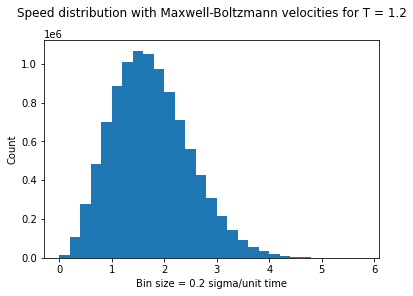

In [ ]:
normally_distributed_velocities = np.random.normal(0,np.sqrt(1.2),(100000,125,3))
plt.hist(speed_hist(normally_distributed_velocities),bins=np.arange(0,6,0.2))
plt.title("Speed distribution with Maxwell-Boltzmann velocities for T = 1.2",y=1.08)
plt.xlabel("Bin size = 0.2 sigma/unit time")
plt.ylabel("Count")
plt.show() 

Analyzing the results above, the thermostatted simulation clearly maintains a much better Maxwell-Boltzmann distribution of particle velocities. This is what we would expect if the thermostat is successfully enforcing a stable temperature (i.e. M-B velocity distribution). By contrast, it looks like the non-thermostatted simulation does not have a M-B distribution of particle veloctiies that is well-defined. In this sense, the simulation temperature is not well-defined at equilibrium. Instead, the simulation maintains a constant total energy, as shown in the total energy / particle graph from **2a**.

To estimate the temperature of the simulation, we note that $$<KE/particle>= \frac{3}{2} k_B T$$ so that 
$$T = \frac{2}{3} <KE/particle>$$

In [ ]:
#estimated temperature at equilibrium:
print("Estimated temperature: {:.3}".format(np.average(res_2b['KE'][20000:]/N)*(2/3)))


Estimated temperature: 1.16


The simulation temperature of $1.16\epsilon / k_B$ is close to the temperature we sought to enforce, $1.2\epsilon / k_B$.


### Problem 2d

For this problem we'll need to start by defining a function that generates radial distribution (pairwise-distance) points from a set of particle trajectories. This involves a little bit of recreation of some functions utilized in the MDSim for parts **2a**-**2c**, but this time outside the MDSim class:

In [ ]:
def rdistrib_PBC(deltas,L): #applies periodic boundary condition / mirror image convention
    mask = np.where(deltas > 0,1,-1) #Make a mask before taking abs value to identify relative positions in each dimension
    boundary_particles = L - np.abs(deltas) #compute periodic boundary particle distance
    return np.where(boundary_particles < np.abs(deltas), np.multiply(-mask,boundary_particles),deltas) #select whether to use mirror particle based on distance, return with proper force orientation

def gen_dist_mat(pos_arr,L): #generates the distance matrix, applying the PBC, for a given set of positions
  deltas = -(pos_arr[:,np.newaxis] - pos_arr) #generates a 3-D array: i, j = particles & k = [x,y,z]
  deltas = rdistrib_PBC(deltas,L)  #applying PBC
  dist_mat = np.linalg.norm(deltas,axis=2)
  np.fill_diagonal(dist_mat,np.nan)
  return dist_mat

def dist_distrib(pos,L,equil=20000,N=125,density=0.85,t=100): #returns a set of pairwise distances for a given simulation
  pos = np.array(pos)
  arr_idxs = np.linspace(equil,pos.shape[0]-1,t).astype(int) #selects t evenly-spaced iterations from the equilibrium set of iterations
  dist_mats = []
  for arr in arr_idxs:
    pos_arr = pos[arr,:]
    dist_mat = gen_dist_mat(pos_arr,L)
    dist_mat = dist_mat.flatten()
    dist_mat = dist_mat[np.logical_not(np.isnan(dist_mat))] #only select non-diagonal distances
    dist_mats.append(dist_mat)
  dist_mats = np.array(dist_mats).flatten()
  return dist_mats

def radial_distrib(pos,L,equil=20000,N=125,density=0.85,dr=0.02,t=100,r_len=5): #returns two ndarrays, (x,y) where x = r values and y = associated g(r) values 
  distances = dist_distrib(pos,L,equil=equil,N=N,density=density,t=t)
  bins = np.arange(0,r_len,dr)
  hist,edges = np.histogram(distances,bins=bins)
  rvals = edges[:-1] + (edges[1:]-edges[:-1])/2 #center each g(r) point in the center of its associated histogram bin
  return rvals,hist/(N*t*L**3 * density)

First let's verify this code works. Below we plot the pairwise-distance distribution for the thermostatted simulation from 2b:

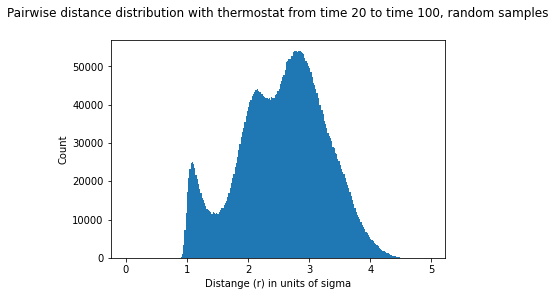

In [ ]:
#getting L
density = 0.85
_, box_size = AssembleCubeLattice(1, density, 5, 5, 5 )
L = box_size[0]
d = dist_distrib(np.array(res_2b["pos"]),L,t=300)
bins = np.arange(0,5,0.02)
plt.hist(d,bins)
plt.title("Pairwise distance distribution with thermostat from time 20 to time 100, random samples",y=1.08)
plt.xlabel("Distange (r) in units of sigma")
plt.ylabel("Count")
plt.show() 

# plt.hist(radial_distrib(res_2b["pos"]),bins='auto')
# plt.show()

This distribution has general features we would expect. Almost no particles are within 1 sigma of each other and on the other end, no particles are more than 5 or so sigmas from each other. This suggests that our Leonard-Jones force and periodic boundary conditions, respectively, are enforcing the proper simulation environment for our particles. Interestingly, for $T=1.2\epsilon / k_B$ it appears that the distance distribution is reminiscent of the solvation shells in a liquid. We'll now run the simulation for various densities to see if there is any phase change behavior picked up by the radial distribution function as density increases. 

In [ ]:
densities = [0.01,0.10,0.85]
res_dict = {}
T = 1.5
for density in densities:
  trials = 100000
  trials_arr = np.array([t for t in range(trials)])
  time_arr = trials_arr/1000
  N = 125
  version = 1
  pickle_file=path+'/pickles/MD_simulation_'+str(N)+'_'+str(density)+'_'+str(T)+'_'+str(trials)+'_'+str(version)+'_'+'thermostat'+'.p'
  res = run_MD(N=N,T=T,t=trials,density=density,path=pickle_file,thermostat=True)
  res_dict["{}".format(density)] = res
  print("\n")

Looks like you have run the simulation with these parameters before. I'll just pull in that data and run the analysis for you:
Loading simulation... Parameters: N = 125 T = 1.5 density = 0.01 t = 100000
Total simulation time: 1280.8s


Looks like you have run the simulation with these parameters before. I'll just pull in that data and run the analysis for you:
Loading simulation... Parameters: N = 125 T = 1.5 density = 0.1 t = 100000
Total simulation time: 1172.9s


Looks like you have run the simulation with these parameters before. I'll just pull in that data and run the analysis for you:
Loading simulation... Parameters: N = 125 T = 1.5 density = 0.85 t = 100000
Total simulation time: 1158.4s




First we plot the kinetic and potential energies of each simulation to see when the simulation converges. We'll run simulations for 100 dimensionless time units, or 100,000 iterations.

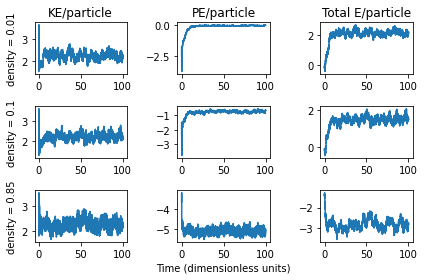

In [ ]:
fig,axs = plt.subplots(3,3)
for i,density in enumerate(densities):
  axs[i,0].set_ylabel('density = {}'.format(density))
  res = res_dict["{}".format(density)]
  axs[i,0].plot(time_arr,res['KE']/N)
  axs[i,1].plot(time_arr,res['PE']/N)
  axs[i,2].plot(time_arr,(res['PE']+res['KE'])/N)

axs[0,0].set_title('KE/particle')
axs[0,1].set_title("PE/particle")
axs[0,2].set_title("Total E/particle")
axs[2,1].set_xlabel('Time (dimensionless units)')
# plt.subplots_adjust(wspace=2,hspace=2)
fig.tight_layout()
plt.show()

Firstly it appears that all three simulations hover around the same KE/particle, corresponding to a successful application of the Anderson thermostat.

Secondly, it appears that for $\rho = 0.01$ or $\rho=0.10$ the potential energy rises to an equilibrium value. This corresponds to the particles spreading out to such a degree that they have relatively few Leonard-Jones interactions. In fact, for $\rho=0.01$, we note that the potential energy of the particle is approximately 0 at equilibrium, meaning that the particles are far enough apart that they have hardly have any interactions.

Thirdly, 20 dimensionless time units seems to reach equilibration for each simulation, so we'll utilize this value as the beginning of our equilibrium measurements below. We now plot the radial distribution function for each system: 


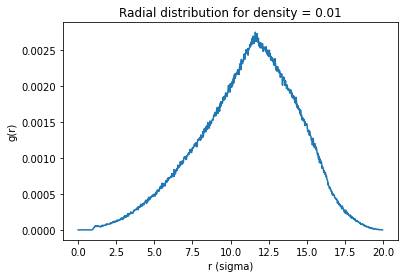

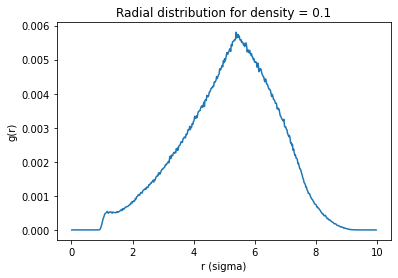

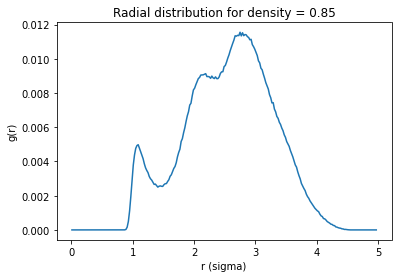

In [ ]:
r_lens = [20,10,5]
for density,r_len in zip(densities,r_lens):
  res = res_dict["{}".format(density)]
  rvals,rdistrib = radial_distrib(res["pos"],res["L"],equil=20000,N=125,density=density,dr=0.02,t=300,r_len=r_len)
  plt.plot(rvals,rdistrib)
  plt.xlabel('r (sigma)')
  plt.ylabel('g(r)')
  plt.title('Radial distribution for density = {}'.format(density))
  plt.show()

For $\rho = 0.85$ we get a radial distribution function with peaks and troughs. This is reminiscent of the radial distribution function for a liquid, shown in class. What's more, the potential energy term is much lower (stronger interactions) at equilibrium than for the other two densities. This seems to indicate that the higher-density fluid acts as a liquid. All particles are within $5\sigma$ of each other- it appears that at equilibrium the denser fluid maintains its liquid structure.

For the other two densities, we see a radial distribution that rises to a peak some distance away, and then falls precipitously to zero. This corresponds to a fluid with roughly evenly-spaced particles. This is corroborated by the potential energy terms which are very small relative to the higher-density simulation, corresponding to particles that are further apart. In other words, our two low-density fluids appear to behave like real gasses, with the lowest-density fluid having the radial distribution peak the furthest distance away. This $\rho=0.01$ system appears to have little to no particle-particle interactions at equilibrium- in that sense it would be safe to treat this fluid as an ideal gas (although the radial distribution is not flat, indicative of some real behavior when particles get close, as well as the periodic boundary conditions).

### Problem 2e

The chemical potential is the change in the free energy with respect to the addition or subtraction of one particle. We can compute this free energy by applying the free energy perturbation method we learned in lecture 18 in class. In this method,

$$\Delta F = -\beta^{-1} \ln(<e^{-\beta \Delta E}>_0)$$

where $\Delta F$ in this situation would represent the free energy change from the perturbation of removing one particle to infinity. The $0$ indicates that we draw configurations from our initial potential energy distribution, the one which (conveniently) we have particle trajectories for. Therefore, the method to compute chemical potential will involve randomly sampling our configurations and computing $\Delta F$ through the above method. I utilize 100,000 random confiugrations drawn from the equilibrium distribution (t=20 to t=100) for each simulation. This represents a sampling of approximately $\frac{100000}{80000*125} = 10\%$ of the saved calculable free energies.

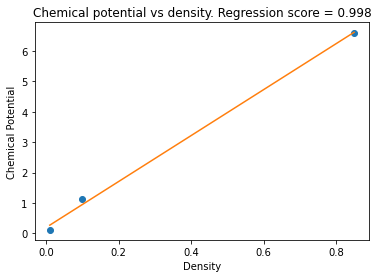

Density = 0.01 Chemical potential = 0.117
Density = 0.1 Chemical potential = 1.13
Density = 0.85 Chemical potential = 6.59


In [ ]:
densities = [0.01,0.10,0.85]
F_dict = {}

force_run = False
version_mu = 1
n = 100000 #number of random samples
pickle_file_mu = 'chemical_potentials' + '_' + '{}'.format(n) + '_' + 'v{}'.format(version_mu) + '.p'
if not os.path.exists(pickle_file_mu) or force_run:
  F_dict = {}
  for density in densities:
    F_arr_temp = []
    trials=100000 #number of iterations in MD simulation, for pickle file
    F_tot = 0
    F_arr = []
    N = 125
    T = 1.5
    version = 1
    pickle_file=path+'/pickles/MD_simulation_'+str(N)+'_'+str(density)+'_'+str(T)+'_'+str(trials)+'_'+str(version)+'_'+'thermostat'+'.p'
    res = run_MD(N=N,T=T,t=trials,density=density,path=pickle_file,thermostat=True)
    print("\n")

    T = res["T"]
    L = res["L"]

    equil = 20000
    pos_search_bounds = (equil,len(res["pos"]))
    res["pos"] = np.array(res["pos"])
    
    num_samples = 0
    print("\nComputing chemical potential for simulation with density = {}".format(density))

    for i in range(n):
      rand_pos_idx = np.random.randint(pos_search_bounds[0],pos_search_bounds[1]) #select random iteration
      pos = copy.deepcopy(res["pos"][rand_pos_idx])
      dist_mat_0 = gen_dist_mat(pos,L) #generate distance matrix
      E_0 = np.nansum(4 * (dist_mat_0**(-12) -dist_mat_0**(-6)))/2
      j = np.random.randint(0,125)
      dist_mat_1 = np.delete(dist_mat_0,j,0) #delete row
      dist_mat_1 = np.delete(dist_mat_1,j,1) #delete column
      E_1 = np.nansum(4 * (dist_mat_1**(-12) -dist_mat_1**(-6)))/2
      F_temp = np.exp(-1/T * (E_1-E_0) )
      F_arr_temp.append(F_temp)

    F_arr_temp = np.array(F_arr_temp)
    print("Temp arr: Avg = {} Std Dev = {}".format(np.average(F_arr_temp),np.std(F_arr_temp)))
    F= -T*np.log(np.average(F_arr_temp))    
    F_dict['{}'.format(density)] = F_arr_temp
    F_dict['{}_T'.format(density)] = T
    print("Density = {} Chemical potential = {:.3}".format(density,F))
    print("\n")
  with open(pickle_file_mu,mode="wb") as f:
    pickle.dump(F_dict,f)


else:
  with open(pickle_file_mu,mode="rb") as f:
    F_dict = pickle.load(f)
chem_potentials = [-1*F_dict['{}_T'.format(density)]*np.log(np.average(F_dict['{}'.format(density)])) for density in densities]

from sklearn.linear_model import LinearRegression
densities_sklearn = np.array(densities).reshape(-1,1)
reg = LinearRegression().fit(densities_sklearn,chem_potentials) #https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
plt.plot(densities,chem_potentials,'o')
plt.plot(densities,reg.coef_*np.array(densities) + reg.intercept_)
plt.title('Chemical potential vs density. Regression score = {:.3}'.format(reg.score(densities_sklearn,chem_potentials)))
plt.xlabel('Density')
plt.ylabel('Chemical Potential')
plt.show()

for density,mu in zip(densities,chem_potentials):
  print("Density = {:.3} Chemical potential = {:.3}".format(density,mu))



Here's the data:

$$\rho = 0.01 \ \ \mu = 0.117$$
$$\rho = 0.10 \ \ \mu = 1.13$$
$$\rho = 0.85 \ \ \mu = 6.59$$

The data seems to indicate that as the density increases, the loss in free energy from removing any one particle goes up. This intuitively makes sense- the higher-density fluid acts as a liquid, indicating that it has stronger intermolecular interactions. As a result, the free energy loss from the removal of a particle would be higher. It in fact looks like a linear relationship, although there aren't enough data points for me to feel comfortable saying that.

### Problem 2 Unit Tests

In [10]:
# https://stackoverflow.com/questions/40172281/unit-tests-for-functions-in-a-jupyter-notebook
class TestNotebook(unittest.TestCase):
    def test_initialization(self):
      # sim = MDSim(N=8)
      # self.assertEqual(8,sim.N)
      pass


    def test_LJ(self):
      sim = MDSim(N=8)
      sim.pos = np.asarray([[0,0.7,0],
                 [0,3.5,0]])
      dist = 1.2
      sim.L = 4
      sim.N = 2

      forces = sim.compute_forces()
      f = -48/dist**2 * ((1/dist)**(12)-0.5 * (1/dist)**6) * (-1.2) #force should be attractive

      self.assertAlmostEqual(0,forces[0][0])
      self.assertAlmostEqual(f,forces[0][1])
      self.assertAlmostEqual(-f,forces[1][1])



if __name__ == '__main__':
    main = TestNotebook()

    # This executes the unit test/(itself)
    import sys
    suite = unittest.TestLoader().loadTestsFromTestCase(TestNotebook)
    unittest.TextTestRunner(verbosity=4,stream=sys.stderr).run(suite)
#unittest.main(argv=[''], verbosity=2, exit=False)

test_LJ (__main__.TestNotebook) ... 

Original temp = 1.223490108751041 , rescaled temp = 1.2


ok
test_initialization (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 2 tests in 1.298s

OK
